<a href="https://colab.research.google.com/github/Jayavathsan/DeepLearning/blob/main/PyTorch/GAN/CNN_Gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN GAN with Gaussians


In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [20]:
%matplotlib notebook

In [21]:
%matplotlib inline

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the data

In [23]:
nImages = 3000
imgSize = 64

x   = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)


# initialize tensors containing images and labels
images = torch.zeros(nImages,1,imgSize,imgSize)

for i in range(nImages):

  # create the gaussian with random centers
  randomOffset = 2*np.random.randn(2)
  randomWidth = np.random.rand()/.6 + 1.8 # random randomWidth
  G  = np.exp( -( (X-randomOffset[0])**2 + (Y-randomOffset[1])**2) / (2*randomWidth**2) )

  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

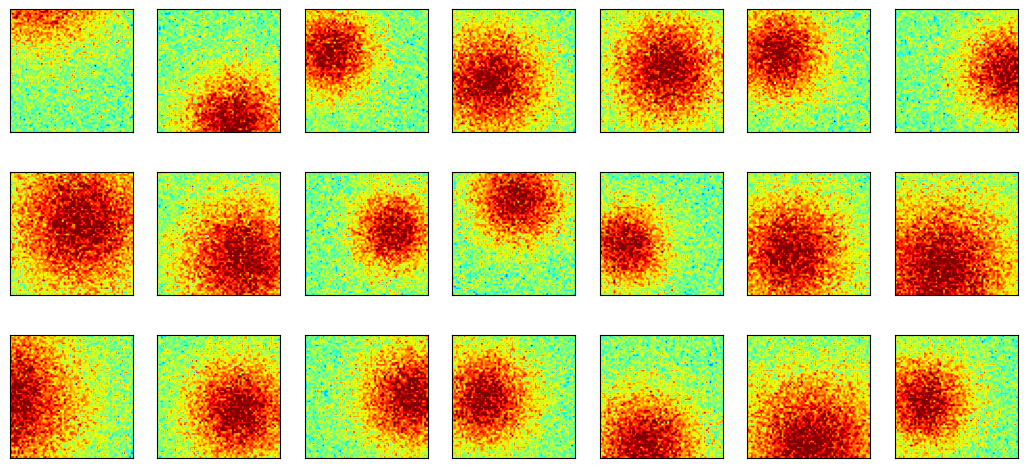

In [24]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nImages)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create classes for the discriminator and generator

In [25]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(  1, 64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)

  def forward(self,x):
    # print(x.shape)
    x = F.leaky_relu( self.conv1(x) ,.2)
    # print(x.shape)
    x = F.leaky_relu( self.conv2(x) ,.2)
    # print(x.shape)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    # print(x.shape)
    x = self.bn3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    # print(x.shape)
    x = self.bn4(x)
    return torch.sigmoid( self.conv5(x) ).view(-1,1)


discriminator = discriminatorNet()
y = discriminator(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

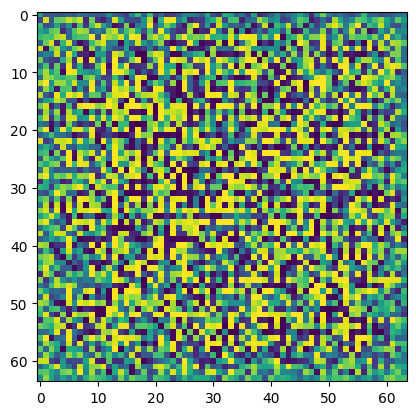

In [26]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100,512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,   1, 4, 2, 1, bias=False)

    # batch normalization layers
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    # print(x.shape)
    x = F.relu( self.bn1(self.conv1(x)) )
    # print(x.shape)
    x = F.relu( self.bn2(self.conv2(x)) )
    # print(x.shape)
    x = F.relu( self.bn3(self.conv3(x)) )
    # print(x.shape)
    x = F.relu( self.bn4(self.conv4(x)) )
    # print(x.shape)
    x = torch.tanh( self.conv5(x) )
    # print(x.shape)
    return x


generator = generatorNet()
y = generator(torch.randn(10,100,1,1))
# print(y.shape)
plt.imshow(y[0,:,:,:].squeeze().detach().numpy());

# Train the models!

In [27]:
lossFunction = nn.BCELoss()

discriminator = discriminatorNet().to(device)
generator = generatorNet().to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=.0002, betas=(.5,.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=.0002, betas=(.5,.999))

In [28]:
# training parameters and initializations
numEpochs = 1500
batchSize  = 128
losses     = []
disDecs    = []


for i in range(numEpochs):

  # minibatch frandomOffsetm randomly selected images
  ridx = torch.randint(images.shape[0],(batchSize,))
  data = images[ridx,:].to(device)


  # labels for real and fake images
  real_labels = torch.ones(batchSize,1).to(device)
  fake_labels = torch.zeros(batchSize,1).to(device)



  ### ---------------- Discriminator training ---------------- ###

  # forward pass and loss for REAL pictures
  pred_real   = discriminator(data)                     # output of discriminator
  d_loss_real = lossFunction(pred_real,real_labels) # all labels are 1

  # forward pass and loss for FAKE pictures
  fake_data   = torch.randn(batchSize,100,1,1).to(device) # random numbers to seed the generator
  fake_images = generator(fake_data)                           # output of generator
  pred_fake   = discriminator(fake_images)                         # pass through discriminator
  d_loss_fake = lossFunction(pred_fake,fake_labels)            # all labels are 0

  # collect loss (using combined losses)
  d_loss = d_loss_real + d_loss_fake

  # backprop
  d_optimizer.zero_grad()
  d_loss.backward()
  d_optimizer.step()



  ### ---------------- Train the generator ---------------- ###

  # create fake images and compute loss
  fake_images = generator( torch.randn(batchSize,100,1,1).to(device) )
  pred_fake   = discriminator(fake_images)

  # compute loss
  g_loss = lossFunction(pred_fake,real_labels)

  # backprop
  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()


  # collect losses and discriminator decisions
  losses.append([d_loss.item(),g_loss.item()])

  d1 = torch.mean((pred_real>.5).float()).detach().cpu()
  d2 = torch.mean((pred_fake>.5).float()).detach().cpu()
  disDecs.append([d1,d2])


  # print out a status message
  if (i+1)%50==0:
    msg = f'Finished epoch {i+1}/{numEpochs}'
    sys.stdout.write('\r' + msg)


# convert performance from list to numpy array
losses  = np.array(losses)
disDecs = np.array(disDecs)

Finished epoch 1500/1500

In [29]:
# create a 1D smoothing filter
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

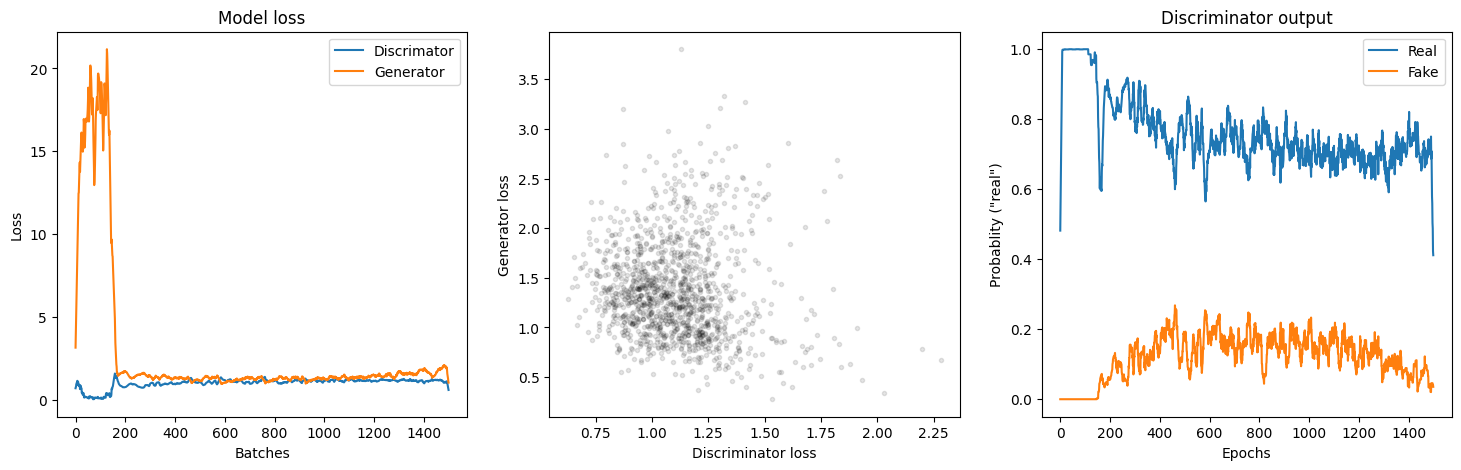

In [30]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500,900])
# ax[0].set_ylim([0,2.5])

ax[1].plot(losses[200:,0],losses[200:,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

# Let's see some generated Gaussians!

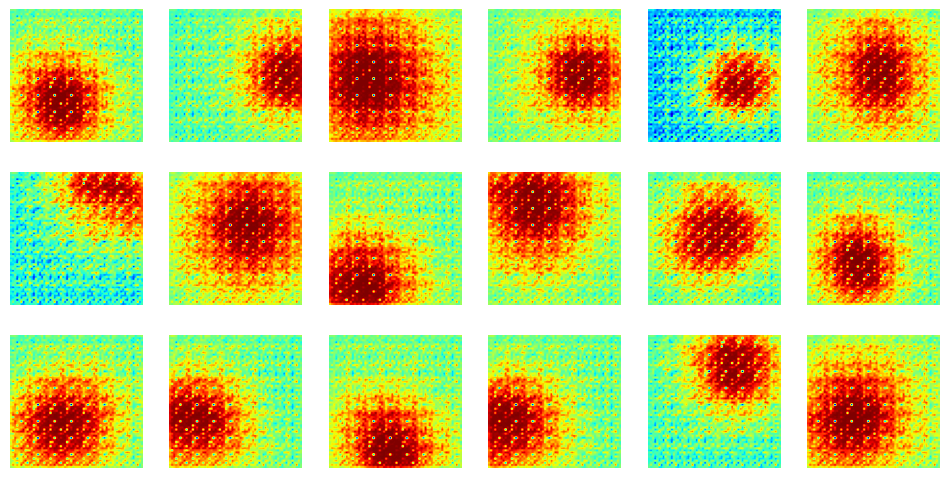

In [31]:
# generate the images from the generator network
generator.eval()
fake_data = generator( torch.randn(batchSize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,].detach().squeeze(),cmap='jet')
  ax.axis('off')

plt.show()

# Architecture and meta-parameters were inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html